In [1]:
import numpy as np
import pandas as pd
import cv2 as cv2

import os
import matplotlib.pyplot as plt

from tensorflow.python.keras import callbacks, optimizers
from tensorflow.python.keras.models import Model, load_model, model_from_json
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.python.keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.metrics import MeanIoU
from tensorflow.keras.applications import InceptionV3

import tensorflow as tf
from tensorflow.keras import backend as K


In [2]:
tf.__version__

'2.5.0'

In [3]:
!pip install -U albumentations

     |████████████████████████████████| 81kB 5.8MB/s 
     |████████████████████████████████| 38.2MB 76kB/s 
     |████████████████████████████████| 952kB 32.8MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
import albumentations as A
A.__version__

'0.5.2'

In [5]:

os.environ['CUDA-DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA-VISIBLE_DEVICE'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
!nvidia-smi

Fri May 28 06:42:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [8]:
!ls /content/gdrive/'My Drive'/data

archive.zip  cats_dogs_dataset.zip


In [9]:
import zipfile
zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/data/cats_dogs_dataset.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()
!ls /content/dataset/

cats_dogs_dataset


In [10]:
directories = '/content/dataset/cats_dogs_dataset/'
valid_dir = directories+'valid/'
train_dir = directories+'train/'

### Уберем расширения и дубли из имен файлов

In [11]:
def list_files():
  files = os.listdir(train_dir) 
  files = [n[:-4] for n in files]
  files = list(set(files))

  val_files = os.listdir(valid_dir) 
  val_files = [n[:-4] for n in val_files]
  val_files = list(set(val_files))

  print(len(files))
  print(len(val_files))

  return files, val_files


files, val_files = list_files()



2985
400


По условию задачи кошек в два раза меньше, увелиличим соотношение кошек/собак до половины, аугментируем зеркально

In [12]:
def cat_aug():
  fc = 0
  # plt.figure(figsize=(20,12))

  for f in files:
    with open(train_dir+f+'.txt', "r") as file:
      line = file.readline().split()
      
    label, x1, y1, x2, y2 = map(int,[line[0], line[1],line[2],line[3],line[4]])
    if label == 1:
      im = cv2.imread(train_dir+f+'.jpg')
      fc+=1

      (h,w) = im.shape[:2]
      transformed_image = cv2.flip(im,1)
      transformed_bboxes = (w-x2,y1,(w-x1)-(w-x2), y2-y1)

      s = str(1)+' ' + str(w-x2)+' '+str(y1)+ ' '+str(w-x1)+' '+str(y2)

      # print((x1, y1, x2-x1, y2-y1))
      # print(fc)

      # cv2.rectangle(im, (x1, y1, x2-x1, y2-y1) , (0, 255, 0), 2)  
      # cv2.rectangle(transformed_image, (transformed_bboxes) , (0, 255, 0), 2)  
      # plt.subplot(2,5,2*fc-1)
      # plt.imshow(im)
      # plt.subplot(2,5,2*fc)
      # plt.imshow(transformed_image)

      cv2.imwrite(train_dir+f+'_flip.jpg',transformed_image)   
      with open(train_dir+f+'_flip.txt', 'w') as f:
        f.write(s)
        f.close() 
  print('Добавлено файлов:'+str(fc))


      



In [13]:
cat_aug()

Добавлено файлов:911


Перечитаем список фалов. 


In [14]:
files, val_files = list_files()

3896
400


Увеличим тренировочный набор методом аугментации

In [15]:
transform = A.Compose([
    # A.RandomCrop(width=450, height=450),    
    # A.Downscale(always_apply=True, p=1),
    # A.RandomBrightnessContrast(p=1),
    A.ShiftScaleRotate(always_apply=True,rotate_limit=20, scale_limit=0.1, shift_limit=0.1,p=1)
], bbox_params=A.BboxParams(format='pascal_voc'))


In [19]:
def aug_all():
  fc = 0
  for f in files:
    fc += 1
    img_val = cv2.imread(train_dir+f+'.jpg')
    with open(train_dir+f+'.txt', "r") as file:
      label = file.readline().split()
    lbl, x1, y1, x2, y2 = map(int,[label[0], label[1],label[2],label[3],label[4]])
    bboxes = [[x1, y1, x2, y2, str(lbl)]]

    transformed = transform(image=img_val, bboxes=bboxes)
    img_tr= transformed['image']
    x1 =int(transformed['bboxes'][0][0])
    y1 =int(transformed['bboxes'][0][1])
    x2 =int(transformed['bboxes'][0][2])
    y2 =int(transformed['bboxes'][0][3])

    cv2.imwrite(train_dir+f+'_ssr2.jpg',img_tr)
    s = str(lbl)+' ' + str(x1)+' '+str(y1)+ ' '+str(x2)+' '+str(y2)
    with open(train_dir+f+'_ssr2.txt', 'w') as f:
      f.write(s)
      f.close() 
  print('Добавлено файлов:'+str(fc))




In [20]:

aug_all()
files, val_files = list_files()


Добавлено файлов:7792
15584
400


In [18]:
files, val_files = list_files()

7792
400


Посмотрим на первые 5 картинок и видно что размеры у всех разные

(225, 300, 3)
/content/dataset/cats_dogs_dataset/train/chihuahua_124_ssr_ssr2.jpg
Координаты 128,24,216,112
(300, 297, 3)
/content/dataset/cats_dogs_dataset/train/Bombay_189_flip.jpg
Координаты 9,4,228,233
(333, 500, 3)
/content/dataset/cats_dogs_dataset/train/British_Shorthair_169_ssr.jpg
Координаты 178,57,286,167
(375, 500, 3)
/content/dataset/cats_dogs_dataset/train/Bengal_121_ssr_ssr2.jpg
Координаты 213,0,428,174
(267, 400, 3)
/content/dataset/cats_dogs_dataset/train/Abyssinian_173_ssr.jpg
Координаты 252,0,328,77


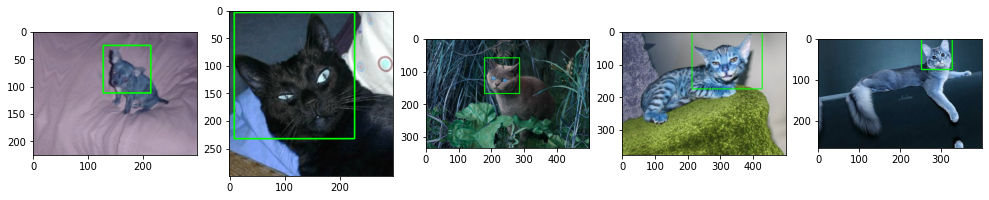

In [21]:
# im = cv2.imread(train_dir+files[0]+'.jpg')
# plt.imshow(im)
plt.figure(figsize=(17,10))
for n in range(5):
    
    im = cv2.imread(train_dir+files[n]+'.jpg')
    
    print(im.shape)
    print(train_dir+files[n]+'.jpg')
    with open(train_dir+files[n]+'.txt', "r") as file:
        line = file.readline().split()
    
    x1, y1, x2, y2 = map(int,[line[1],line[2],line[3],line[4]])    
    cv2.rectangle(im, (x1, y1, x2-x1, y2-y1) , (0, 255, 0), 2)    
    print('Координаты {},{},{},{}'.format(x1, y1, x2, y2))
    plt.subplot(1,5,n+1)
    plt.imshow(im)  




In [23]:
losses= {'CLASS':'categorical_crossentropy',
        'ROI': 'mean_squared_error',}

lossWeight = {'CLASS':1.0, 'ROI':1.0}




Функция для вычисления IoU

In [22]:
def iou(y_true, y_pred):
#     print(y_true)
#     print(y_pred)
    
    # y_true = K.flatten(y_true)
    # y_pred = K.flatten(y_pred)
#     print(y_true)
#     print(y_pred)
    xa = max(y_true[0], y_pred[0])
    ya = max(y_true[1], y_pred[1])
    xb = min(y_true[2], y_pred[2])
    yb = min(y_true[3], y_pred[3])
    
    interArea = max(0, xb-xa+1) * max(0, yb-ya+1)  
    
    boxAArea = (y_true[2] - y_true[0]+1)*(y_true[3]-y_true[1]+1)
    boxBArea = (y_pred[2] - y_pred[0]+1)*(y_pred[3]-y_pred[1]+1) 
    
    miou=interArea/(boxAArea+boxBArea-interArea)    
    return miou


Создание модели с двумя выходами

In [23]:
image_shape = (192,192)

def CNN(input_shape= (image_shape[0],image_shape[1], 3)):
  inp = Input(input_shape)
  # Block 1
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(inp)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
  block_1_out = Activation('relu')(x)
  x = MaxPooling2D()(block_1_out)
  # Block 2
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
  block_2_out = Activation('relu')(x)
  x = MaxPooling2D()(block_2_out)
  # Block 3
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
  block_3_out = Activation('relu')(x)
  x = MaxPooling2D()(block_3_out)

  x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
  block_4_out = Activation('relu')(x)
  x = MaxPooling2D()(block_4_out)


  

  flatten = Flatten()(x)

   
 
  x1 = Dense(128, activation='relu')(flatten)
  x1 = Dropout(0.3)(x1)
  x1 = Dense(64, activation='relu')(x1)
  x1 = Dropout(0.3)(x1)
  x1 = Dense(32, activation='relu')(x1)
  # x1 = Dense(64, activation='relu')(x1)
  # x1 = Dropout(0.1)(x1)
  x1 = Dense(4, activation='sigmoid', name = 'ROI')(x1)

  x2 = Dense(128, activation='relu')(flatten)
  x2 = Dropout(0.3)(x2)
  x2 = Dense(64, activation='relu')(x2)
  x2 = Dropout(0.3)(x2)
  x2 = Dense(32, activation='relu')(x2)
  # x2 = Dense(64, activation='relu')(x2)
  x2 = Dense(2, activation='softmax', name = 'CLASS')(x2)
  
 
  model = Model(inputs=inp, outputs=[x1,x2])
  adam = tf.keras.optimizers.Adam(lr=0.0001)
  
  model.compile(optimizer=adam,
                  loss=['MSE','categorical_crossentropy'],
                  metrics=['accuracy'],
                  loss_weights = lossWeight)
    # model.summary()
  return model
    

In [24]:
model = CNN()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


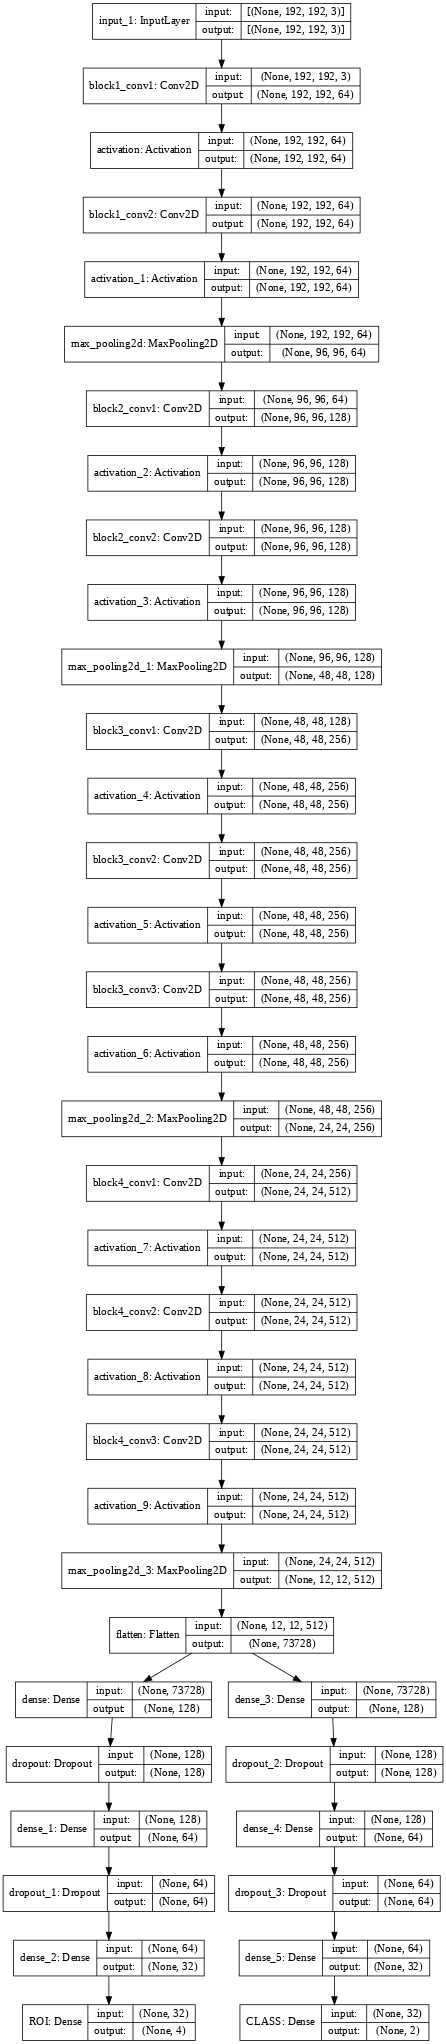

In [25]:
tf.keras.utils.plot_model(model, show_shapes = True, expand_nested = True, dpi = 56)

In [24]:

    

def train_generator(folder,file_list, batch_size):
#     list_images = os.listdir(label_dir)
    # shuffle(list_images) #Randomize the choice of batches
    ids_train_split = range(len(file_list))

    while True:
         for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y1_batch = []
            y2_batch = []

            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]

            for id in ids_train_batch:
              img_name = folder + file_list[id]+'.jpg'
              label_name = folder + file_list[id]+'.txt'
  
              img = cv2.imread(img_name)
              (h,w) = img.shape[:2]
              img  = cv2.resize(img, image_shape, interpolation=cv2.INTER_AREA)
  
              with open(label_name, "r") as file:
                  label = file.readline().split()
              
              x1, y1, x2, y2 = map(int,[label[1],label[2],label[3],label[4]]) 
              lbl = to_categorical(int(label[0])-1, num_classes=2)
               
              
              x_batch  += [img]
              y1_batch += [[x1/w, y1/h, x2/w, y2/h]] 
              y2_batch += [lbl] 
    
            x_batch = np.array(x_batch, dtype = "float32") / 255.
            y1_batch = np.array(y1_batch, dtype = "float32")             
            y2_batch = np.array(y2_batch)
            
#             
            yield x_batch, (y1_batch, y2_batch)
        
    


In [27]:
BATCH_SIZE=24
history = model.fit_generator(train_generator(train_dir, files, batch_size = BATCH_SIZE),                              
                              steps_per_epoch=649,
                              epochs=40,
                              verbose=1,
                              # callbacks=callbacks,
                              validation_data=train_generator(valid_dir, val_files, batch_size = 10),
                              validation_steps=40,
                              class_weight=None,
                              max_queue_size=10,
                              workers=1
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
649/649 [==============================] - 181s 221ms/step - loss: 0.7228 - ROI_loss: 0.0311 - CLASS_loss: 0.6917 - ROI_accuracy: 0.6674 - CLASS_accuracy: 0.5257 - val_loss: 0.7032 - val_ROI_loss: 0.0203 - val_CLASS_loss: 0.6830 - val_ROI_accuracy: 0.7250 - val_CLASS_accuracy: 0.6850
Epoch 2/40
649/649 [==============================] - 145s 220ms/step - loss: 0.7191 - ROI_loss: 0.0282 - CLASS_loss: 0.6910 - ROI_accuracy: 0.6942 - CLASS_accuracy: 0.5308 - val_loss: 0.6936 - val_ROI_loss: 0.0210 - val_CLASS_loss: 0.6726 - val_ROI_accuracy: 0.7250 - val_CLASS_accuracy: 0.6850
Epoch 3/40
649/649 [==============================] - 144s 221ms/step - loss: 0.7164 - ROI_loss: 0.0282 - CLASS_loss: 0.6882 - ROI_accuracy: 0.6945 - CLASS_accuracy: 0.5330 - val_loss: 0.7106 - val_ROI_loss: 0.0209 - val_CLASS_loss: 0.6897 - val_ROI_accuracy: 0.7250 - val_CLASS_accuracy: 0.6850
Epoch 4/40
649/649 [==============================] - 142s 219ms/step - loss: 0.7190 - ROI_loss: 0.0273 - CLASS_

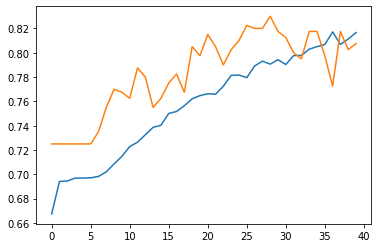

In [28]:

#ROI history
plt.plot(history.history['ROI_accuracy'])
plt.plot(history.history['val_ROI_accuracy'])


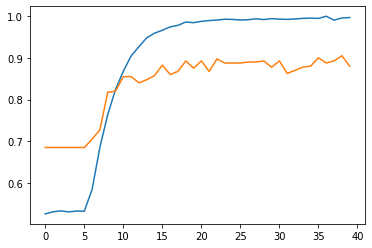

In [29]:
#class history
plt.plot(history.history['CLASS_accuracy'])
plt.plot(history.history['val_CLASS_accuracy'])

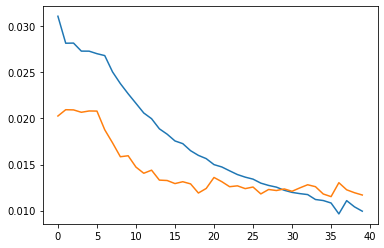

In [30]:
plt.plot(history.history['ROI_loss'])
plt.plot(history.history['val_ROI_loss'])

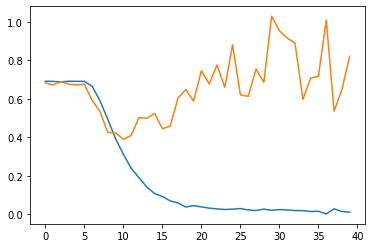

In [31]:
plt.plot(history.history['CLASS_loss'])
plt.plot(history.history['val_CLASS_loss'])

In [32]:
model.save(directories+'model/cat_dog.h5')
model_json = model.to_json()
json_file = open(directories+"model/cat_dog.json", "w")
json_file.write(model_json)
json_file.close()
model.save_weights(directories+"model/cat_dog_weight.h5")

In [33]:
img_val = cv2.imread(valid_dir+'keeshond_149.jpg')
(h,w) = img_val.shape[:2]
img_val = cv2.resize(img_val, image_shape, interpolation=cv2.INTER_AREA)
img_val = np.expand_dims(img_val, 0)
img_val = img_val /255
img_val.shape


(1, 192, 192, 3)

In [34]:
predict = model.predict(img_val)
predict[0]

array([[0.35108733, 0.0690233 , 0.76872975, 0.49220988]], dtype=float32)

In [35]:

x1 = int(predict[0][0][0]*192)
y1 = int(predict[0][0][1]*192)
x2 = int(predict[0][0][2]*192)
y2 = int(predict[0][0][3]*192)


c =cv2.rectangle(img_val[0], (x1, y1, x2-x1, y2-y1) , (0, 255, 0), 2)
(x1, y1, x2, y2)

(67, 13, 147, 94)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


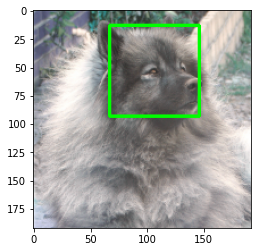

In [36]:
plt.imshow(img_val[0])

In [37]:
def draw_image(img,lbl):
  lbl_list = ['CAT', 'DOG']
  plt.figure(figsize=(5,5))
  plt.subplot(1,1,1)
  plt.imshow(img)
  plt.title(lbl_list[lbl])


In [53]:
from statistics import mean
import time
start_time = time.time()

IOU = []
TIME = []
ACC = 0

for f in val_files:
  
  img_val =cv2.imread(valid_dir+f+'.jpg')
  (h,w) = img_val.shape[:2]
  
  img_val = cv2.resize(img_val, image_shape, interpolation=cv2.INTER_AREA)
  img_val = np.expand_dims(img_val, 0)
  img_val = img_val /255
  
  with open(valid_dir+f+'.txt', "r") as file:
    label = file.readline().split()
              
  x1, y1, x2, y2 = map(int,[label[1],label[2],label[3],label[4]]) 
  lbl = int(label[0])

  start_time = time.time()
  predict = model.predict(img_val)
  time_res = time.time() - start_time

  TIME.append(time_res)

  xp1 = predict[0][0][0]
  yp1 = predict[0][0][1]
  xp2 = predict[0][0][2]
  yp2 = predict[0][0][3]

  lbl_p = np.argmax(predict[1])+1

  if lbl == lbl_p:
    ACC+=1

  IOU.append(iou([x1/w, y1/h, x2/w, y2/h],[xp1, yp1, xp2, yp2]))
  
  

In [62]:
print('mIoU: {}%, classification accuracy: {}%, {}ms {} train, {} valid'.format(round(mean(IOU)*100), ACC/len(val_files)*100, mean(TIME), len(files),len(val_files)))

mIoU: 81%, classification accuracy: 88.0%, 0.04455575942993164ms 15584 train, 400 valid


#Inception

Создадим модель Inception V3 и загрузим веса сети обученную на наборе данных ImageNET. 

In [76]:
inception_model = InceptionV3(include_top=False, 
                      weights='imagenet', 
                      input_shape=((192, 192, 3)))

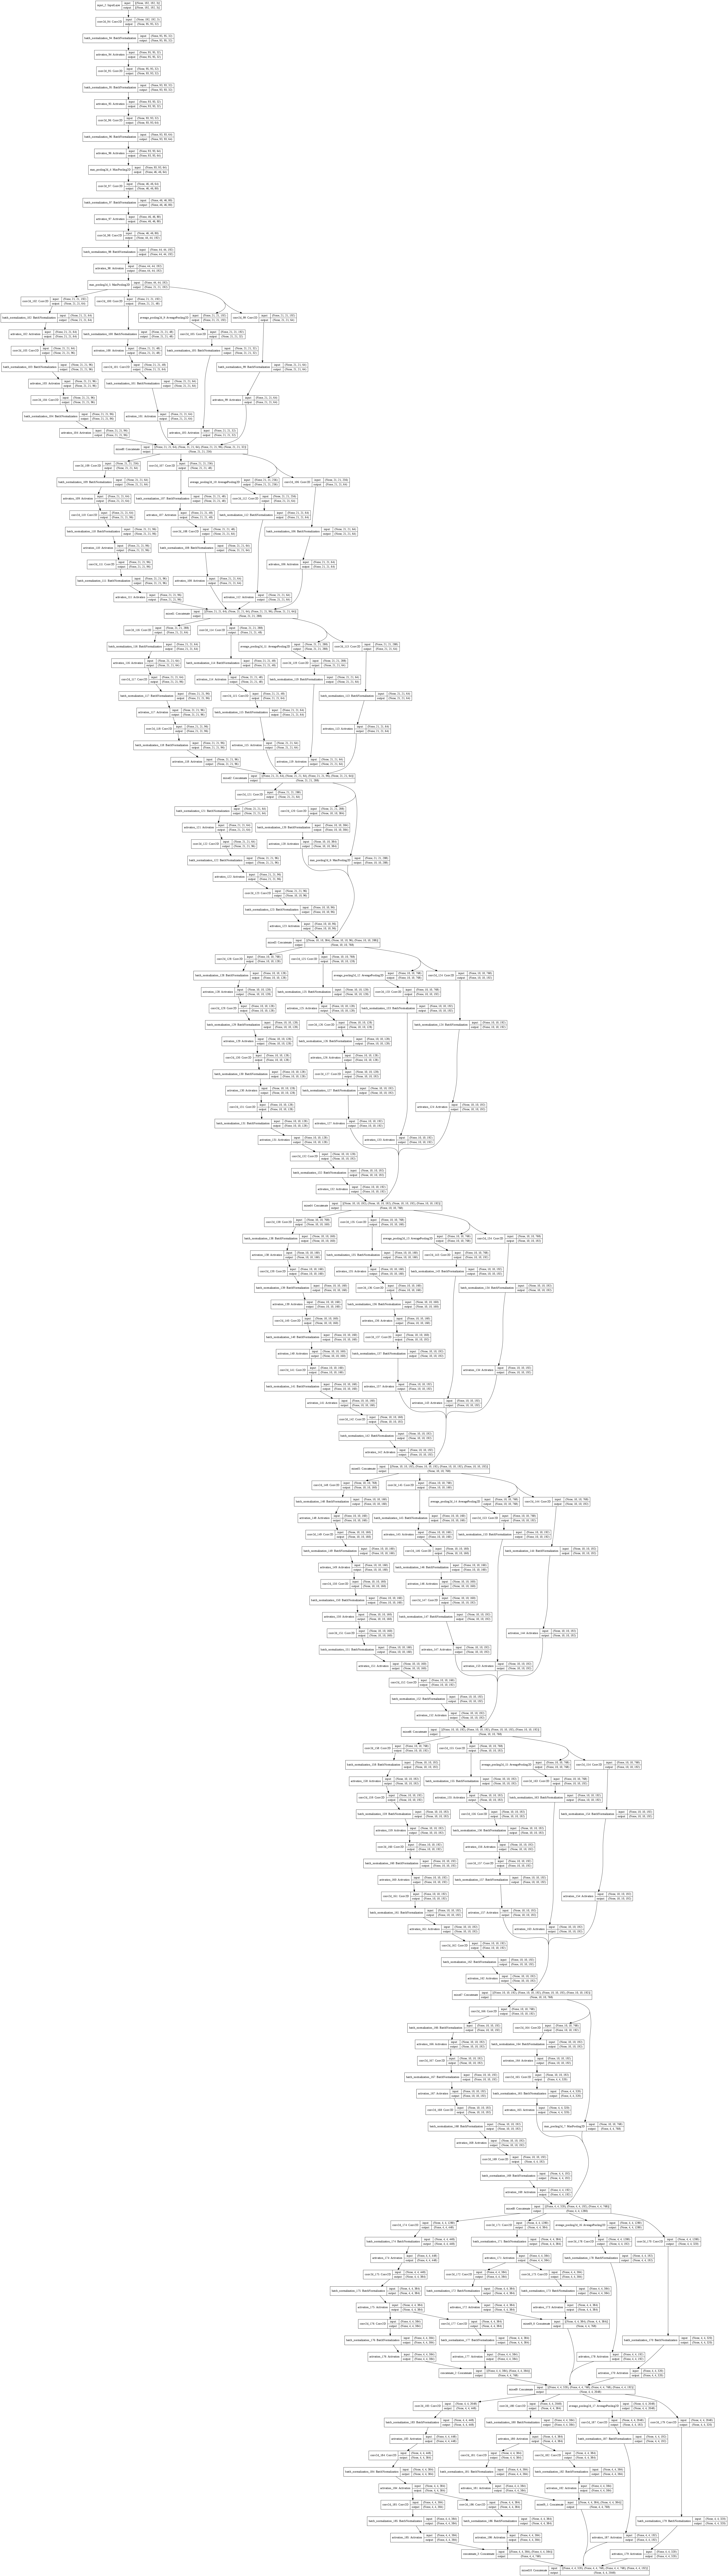

In [77]:
tf.keras.utils.plot_model(inception_model, show_shapes = True, expand_nested = True, dpi = 72)

In [104]:
image_shape = (192,192)

flatten = Flatten()(inception_model.output)
x1 = Dense(256, activation='relu')(flatten)
x1 = Dropout(0.3)(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(64, activation='relu')(x1)
x1 = Dense(4, activation='sigmoid', name = 'ROI')(x1)

x2 = Dense(128, activation='relu')(flatten)
x2 = Dropout(0.3)(x2)
x2 = Dense(64, activation='relu')(x2)
x2 = Dropout(0.3)(x2)
x2 = Dense(32, activation='relu')(x2)

x2 = Dense(2, activation='softmax', name = 'CLASS')(x2)
  
 
model2 = Model(inputs=inception_model.input, outputs=[x1,x2])
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
  


In [105]:
len(model2.layers)



324

Заморозим для обучения веса сети, кроме последних добавленных полносвязных 12 слоев

In [106]:
for layer in model2.layers[:-12]:
    layer.trainable = False

In [107]:
model2.compile(optimizer=adam,
                  loss=['MSE','categorical_crossentropy'],
                  metrics=['accuracy'],
                  loss_weights = lossWeight)

In [108]:
BATCH_SIZE=32
history2 = model2.fit_generator(train_generator(train_dir, files, batch_size = BATCH_SIZE),                              
                              steps_per_epoch=487,
                              epochs=15,
                              verbose=1,
                              validation_data=train_generator(valid_dir, val_files, batch_size = 10),
                              validation_steps=40,
                              class_weight=None,
                              max_queue_size=10,
                              workers=1
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
487/487 [==============================] - 95s 186ms/step - loss: 0.1654 - ROI_loss: 0.0328 - CLASS_loss: 0.1327 - ROI_accuracy: 0.6804 - CLASS_accuracy: 0.9524 - val_loss: 0.0453 - val_ROI_loss: 0.0123 - val_CLASS_loss: 0.0330 - val_ROI_accuracy: 0.8550 - val_CLASS_accuracy: 0.9850
Epoch 2/15
487/487 [==============================] - 90s 185ms/step - loss: 0.0781 - ROI_loss: 0.0162 - CLASS_loss: 0.0619 - ROI_accuracy: 0.7456 - CLASS_accuracy: 0.9781 - val_loss: 0.0530 - val_ROI_loss: 0.0108 - val_CLASS_loss: 0.0422 - val_ROI_accuracy: 0.8600 - val_CLASS_accuracy: 0.9850
Epoch 3/15
487/487 [==============================] - 90s 185ms/step - loss: 0.0607 - ROI_loss: 0.0136 - CLASS_loss: 0.0472 - ROI_accuracy: 0.7765 - CLASS_accuracy: 0.9826 - val_loss: 0.0552 - val_ROI_loss: 0.0093 - val_CLASS_loss: 0.0458 - val_ROI_accuracy: 0.8400 - val_CLASS_accuracy: 0.9825
Epoch 4/15
487/487 [==============================] - 90s 185ms/step - loss: 0.0492 - ROI_loss: 0.0116 - CLASS_loss

In [109]:
from statistics import mean
import time
start_time = time.time()

IOU = []
TIME = []
ACC = 0

for f in val_files:
  
  img_val =cv2.imread(valid_dir+f+'.jpg')
  (h,w) = img_val.shape[:2]
  
  img_val = cv2.resize(img_val, image_shape, interpolation=cv2.INTER_AREA)
  img_val = np.expand_dims(img_val, 0)
  img_val = img_val /255
  
  with open(valid_dir+f+'.txt', "r") as file:
    label = file.readline().split()
              
  x1, y1, x2, y2 = map(int,[label[1],label[2],label[3],label[4]]) 
  lbl = int(label[0])

  start_time = time.time()
  predict = model2.predict(img_val)
  time_res = time.time() - start_time

  TIME.append(time_res)

  xp1 = predict[0][0][0]
  yp1 = predict[0][0][1]
  xp2 = predict[0][0][2]
  yp2 = predict[0][0][3]

  lbl_p = np.argmax(predict[1])+1

  if lbl == lbl_p:
    ACC+=1

  IOU.append(iou([x1/w, y1/h, x2/w, y2/h],[xp1, yp1, xp2, yp2]))
  

In [110]:
print('mIoU: {}%, classification accuracy: {}%, {}ms {} train, {} valid'.format(round(mean(IOU)*100), ACC/len(val_files)*100, mean(TIME), len(files),len(val_files)))

mIoU: 84%, classification accuracy: 98.75%, 0.18686294734477996ms 15584 train, 400 valid
